In [39]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from PIL import Image
from tqdm import tqdm
from torchvision.models import efficientnet_b2
from itertools import cycle
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize


In [40]:
# ..\dataset\malaria\images\41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg
print(os.listdir('../dataset/malaria/images'))
im_f = os.listdir('../dataset/malaria/images')
for i in im_f:
    if i == '41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg':
        print('found', i)

['002f20ad-2ace-499c-9335-c9080bc3e6b5.png', '003a89b0-a095-417a-8dd6-f408339bbc68.png', '003d1cdc-0aec-430b-90e0-f4d82135b1ac.png', '005e60b6-77b8-458c-b57c-bfe0c7e7df78.png', '00a02700-2ea2-4590-9e15-ffc9160fd3de.png', '00c8364b-8c85-4502-bcfe-64736fe76815.png', '00d04a90-80e5-4bce-9511-1b64eabb7a47.png', '010961af-b38c-49de-aca0-e3732d73d414.jpg', '0154dd8e-72f8-4d78-a4dd-93e139577bd1.png', '01b38a56-13eb-447b-89ee-fc21cb40dcc1.png', '01b99da8-b66b-464b-a7ee-1cadab8db18b.png', '027ab174-e47a-44f8-b85b-372449eeb7d8.png', '02ea7aa8-c142-4a3d-939f-e77689741341.png', '02fb5e19-6f94-4787-bb78-e550a29a3cbd.png', '030f3421-ed3f-4bf1-8f27-4d02590bffbc.png', '03359d4d-69cb-4146-8286-ca7399366f97.png', '0346611b-ea43-45bd-9f16-c6e8086273d2.jpg', '034c8d57-04d5-4786-93a4-6ae8fde2c258.png', '035f6c4b-0897-46ab-9c3b-5f3b0feff043.png', '036404d1-b9fc-497b-bbe1-f4d9c5ac3ce0.png', '036e008f-07a1-4e92-899d-1822dc390ccb.png', '03b9d6ad-39ca-4097-a98b-77f02b3c00a7.png', '03be08c8-2cf3-4de6-8ac6-5f7817

In [41]:
root_path = os.path.join('..', 'dataset', 'malaria')
train_json_path = os.path.join(root_path, 'training_stratified.json')
test_json_path = os.path.join(root_path, 'test_stratified.json')
results_path = os.path.join('..','effecientnetb2_model','efficientnet_models','grid_search_results.json')
models_dir = os.path.join('..','effecientnetb2_model','efficientnet_models')
image_path = os.path.join('..','dataset','malaria','images')

In [42]:
import json
import pandas as pd

def plotting_cells_count(training_dataset_json):
    # Loading the JSON
    with open(training_dataset_json, 'r') as f:
        training_metadata = json.load(f)

    # Extracting all object categories into a list
    all_categories = []
    for item in training_metadata:
        for obj in item['objects']:
            all_categories.append(obj['category'])

    # Create DataFrame and count categories
    df = pd.DataFrame(all_categories, columns=['category'])
    category_counts = df['category'].value_counts()

    return category_counts.to_dict()

# Example usage
# train_json_path = r"D:\fyp\fyp\train.json"
counts = plotting_cells_count(train_json_path)
print(counts)
counts2 = plotting_cells_count(test_json_path)
print(counts2)


{'red blood cell': 76165, 'trophozoite': 1416, 'difficult': 430, 'ring': 349, 'schizont': 178, 'gametocyte': 142, 'leukocyte': 82}
{'red blood cell': 6869, 'ring': 173, 'trophozoite': 168, 'leukocyte': 21, 'difficult': 16, 'gametocyte': 14, 'schizont': 12}


In [43]:
import json

print("--- Checking the category of the FIRST object for each image in the test set ---")

with open(test_json_path, 'r') as f:
    test_metadata = json.load(f)

for i in range(20): # Look at the first 20 images
    item = test_metadata[i]
    if item['objects']:
        first_object_category = item['objects'][0]['category']
        print(f"Image {i}: The first object is a '{first_object_category}'")
    else:
        print(f"Image {i}: Has no objects.")

--- Checking the category of the FIRST object for each image in the test set ---
Image 0: The first object is a 'red blood cell'
Image 1: The first object is a 'red blood cell'
Image 2: The first object is a 'red blood cell'
Image 3: The first object is a 'red blood cell'
Image 4: The first object is a 'red blood cell'
Image 5: The first object is a 'red blood cell'
Image 6: The first object is a 'red blood cell'
Image 7: The first object is a 'red blood cell'
Image 8: The first object is a 'red blood cell'
Image 9: The first object is a 'red blood cell'
Image 10: The first object is a 'red blood cell'
Image 11: The first object is a 'red blood cell'
Image 12: The first object is a 'red blood cell'
Image 13: The first object is a 'red blood cell'
Image 14: The first object is a 'red blood cell'
Image 15: The first object is a 'red blood cell'
Image 16: The first object is a 'red blood cell'
Image 17: The first object is a 'red blood cell'
Image 18: The first object is a 'red blood cell

In [44]:
# Function to count entries in a JSON file
def count_json_entries(file_path):
    if not os.path.exists(file_path):
        print(f"Error: The file path '{file_path}' does not exist.")
        return 0
    
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Assuming the JSON data is a list of entries
    return len(data)

# Count entries in each file
train_count = count_json_entries(train_json_path)
test_count = count_json_entries(test_json_path)

# Print the results
print(f"Number of entries in training.json: {train_count}")
print(f"Number of entries in test.json: {test_count}")

Number of entries in training.json: 1190
Number of entries in test.json: 138


In [45]:
# Load the grid search results
with open(results_path, 'r') as f:
    all_results = json.load(f)

# Convert to a DataFrame for easy analysis
results_df = pd.DataFrame(all_results)

# The 'params' column is a dictionary, let's expand it for better sorting
params_df = pd.json_normalize(results_df['params'])
results_df = pd.concat([results_df.drop('params', axis=1), params_df], axis=1)

# Sort by accuracy to find the best run
results_df = results_df.sort_values(by='best_accuracy', ascending=False).reset_index(drop=True)

print("--- Top 5 Performing Models ---")
display(results_df.head())

--- Top 5 Performing Models ---


,best_accuracy,training_time_minutes,history,lr,optimizer,batch_size,sampling,image_size
0,94.799054,47.760783,"{'train_loss': [9.133223307760138, 8.397412940...",0.0010,Adam,32,oversample,224
1,94.799054,25.002517,"{'train_loss': [16.83139763380352, 15.91469799...",0.0010,Adam,32,oversample,128
2,94.799054,48.497283,"{'train_loss': [9.836383957611886, 8.620703860...",0.0010,SGD,32,oversample,224
3,94.799054,48.624517,"{'train_loss': [9.700505482523065, 8.685548355...",0.0010,SGD,32,none,224
4,94.799054,27.238550,"{'train_loss': [17.683489924982975, 16.0491562...",0.0001,Adam,32,none,128


In [46]:
import matplotlib.pyplot as plt

def plot_training_history(history, params):
    """
    Plots the training and validation loss and accuracy curves from a history dictionary.
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    
    # Create an array for the x-axis (epochs)
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Plot 1: Loss vs. Epochs ---
    ax[0].plot(epochs, history['train_loss'], label='Train Loss', color='royalblue', marker='o', linestyle='--')
    ax[0].plot(epochs, history['val_loss'], label='Validation Loss', color='darkorange', marker='o')
    ax[0].set_title('Loss Over Epochs', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=12)
    ax[0].set_ylabel('Loss', fontsize=12)
    ax[0].legend()
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.5)

    # --- Plot 2: Accuracy vs. Epochs ---
    ax[1].plot(epochs, history['train_accuracy'], label='Train Accuracy', color='royalblue', marker='s', linestyle='--')
    ax[1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='green', marker='s')
    ax[1].set_title('Accuracy Over Epochs', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=12)
    ax[1].set_ylabel('Accuracy (%)', fontsize=12)
    ax[1].legend()
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.5)

    # Create a comprehensive title for the entire figure
    param_str = ', '.join([f'{k}={v}' for k, v in params.items()])
    fig.suptitle(f'Training History for Best Model: {param_str}', fontsize=20)
    
    # Adjust layout to prevent title overlap
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

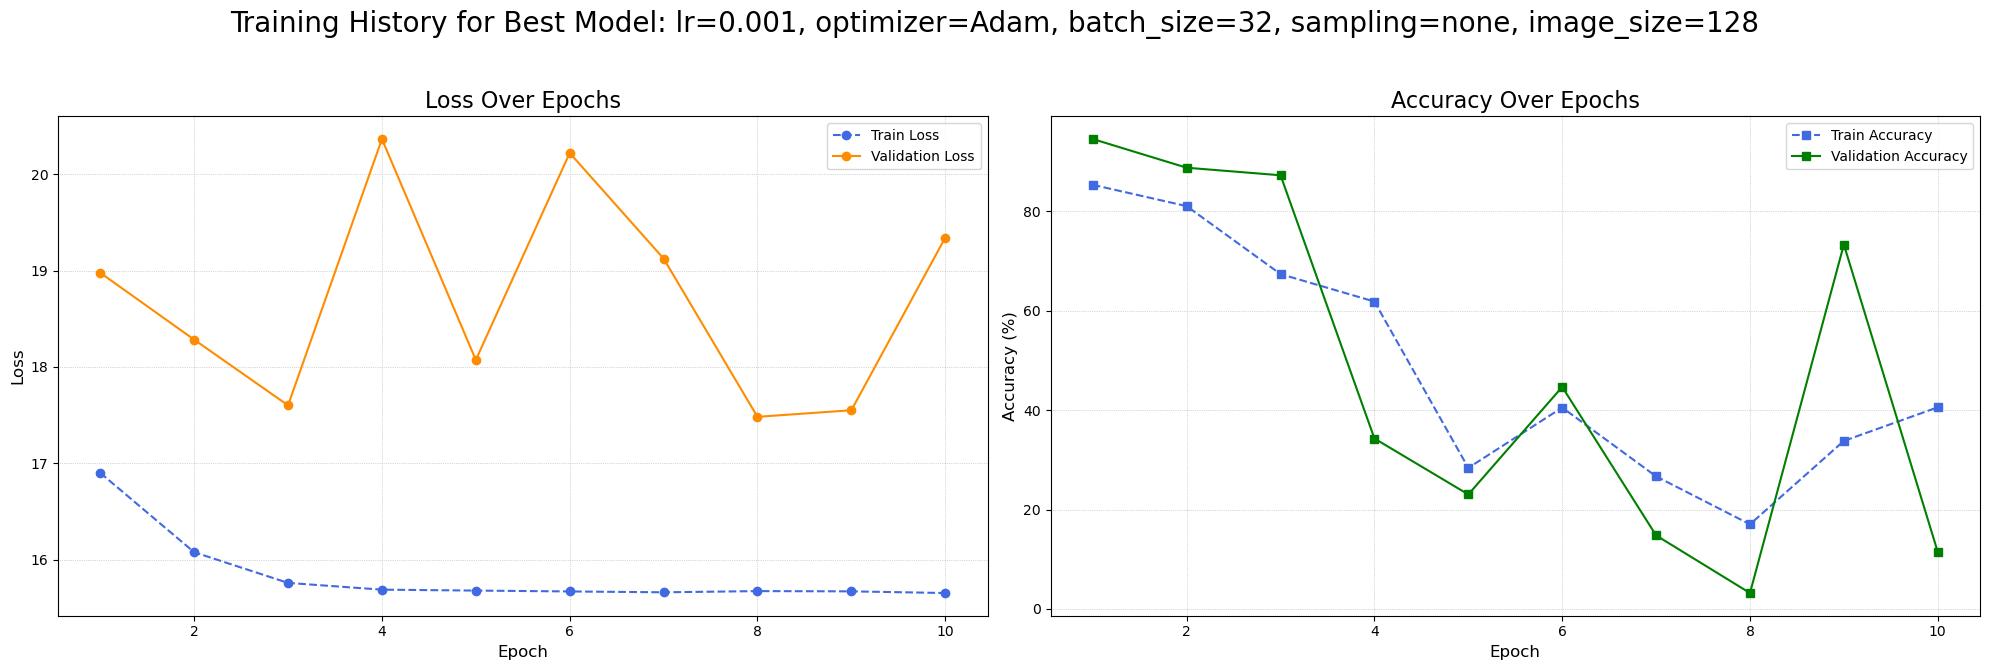

In [47]:
# The history is a string in the JSON, so we need to get it from the original list
best_run_dict = all_results[results_df.index[0]]
best_history = best_run_dict['history']
best_params = best_run_dict['params']

plot_training_history(best_history, best_params) # Use the plotting function from our previous discussion

In [48]:
def plot_all_grid_search_results(all_results):
    """
    Plots the validation loss and accuracy for all experiments from a grid search on a single graph.
    """
    fig, ax = plt.subplots(1, 2, figsize=(24, 10))
    
    # Define styles to cycle through to make lines distinguishable
    linestyles = ['-', '--', ':', '-.']
    markers = ['o', 's', 'v', '^', 'D', '<', '>', 'p']
    # Generate a list of distinct colors
    colors = plt.cm.get_cmap('tab20', len(all_results))

    # --- Loop through each experiment's results ---
    for i, result in enumerate(all_results):
        history = result['history']
        params = result['params']
        
        # Create a short, descriptive label for the legend
        samp_char = 'O' if params.get('sampling', 'none') == 'oversample' else 'N'
        label = f"Run {i+1}: lr={params['lr']}, optim={params['optimizer'][:3]}, size={params['image_size']}, samp={samp_char}"

        epochs = range(1, len(history['val_loss']) + 1)
        
        # Get unique styles for the plot
        style = linestyles[i % len(linestyles)]
        marker = markers[i % len(markers)]
        color = colors(i)

        # --- Plot 1: Validation Loss vs. Epochs ---
        ax[0].plot(epochs, history['val_loss'], label=label, color=color, linestyle=style, marker=marker, markersize=5)
        
        # --- Plot 2: Validation Accuracy vs. Epochs ---
        ax[1].plot(epochs, history['val_accuracy'], label=label, color=color, linestyle=style, marker=marker, markersize=5)

    # --- Formatting for the Loss Plot ---
    ax[0].set_title('Validation Loss Comparison', fontsize=18)
    ax[0].set_xlabel('Epoch', fontsize=14)
    ax[0].set_ylabel('Loss', fontsize=14)
    ax[0].grid(True, which='both', linestyle=':', linewidth=0.7)
    
    # --- Formatting for the Accuracy Plot ---
    ax[1].set_title('Validation Accuracy Comparison', fontsize=18)
    ax[1].set_xlabel('Epoch', fontsize=14)
    ax[1].set_ylabel('Accuracy (%)', fontsize=14)
    ax[1].grid(True, which='both', linestyle=':', linewidth=0.7)
    
    # --- Create a single, shared legend outside the plot area ---
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=12, title="Experiments")

    # --- Overall Figure Title and Layout Adjustment ---
    fig.suptitle('Comparison of All 16 Grid Search Experiments', fontsize=24)
    fig.tight_layout(rect=[0, 0, 0.85, 0.96]) # Adjust layout to make space for the legend and title
    
    plt.show()

Plotting a comparison of all 16 experiments...


C:\Users\shera\AppData\Local\Temp\ipykernel_13848\2453710040.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(all_results))


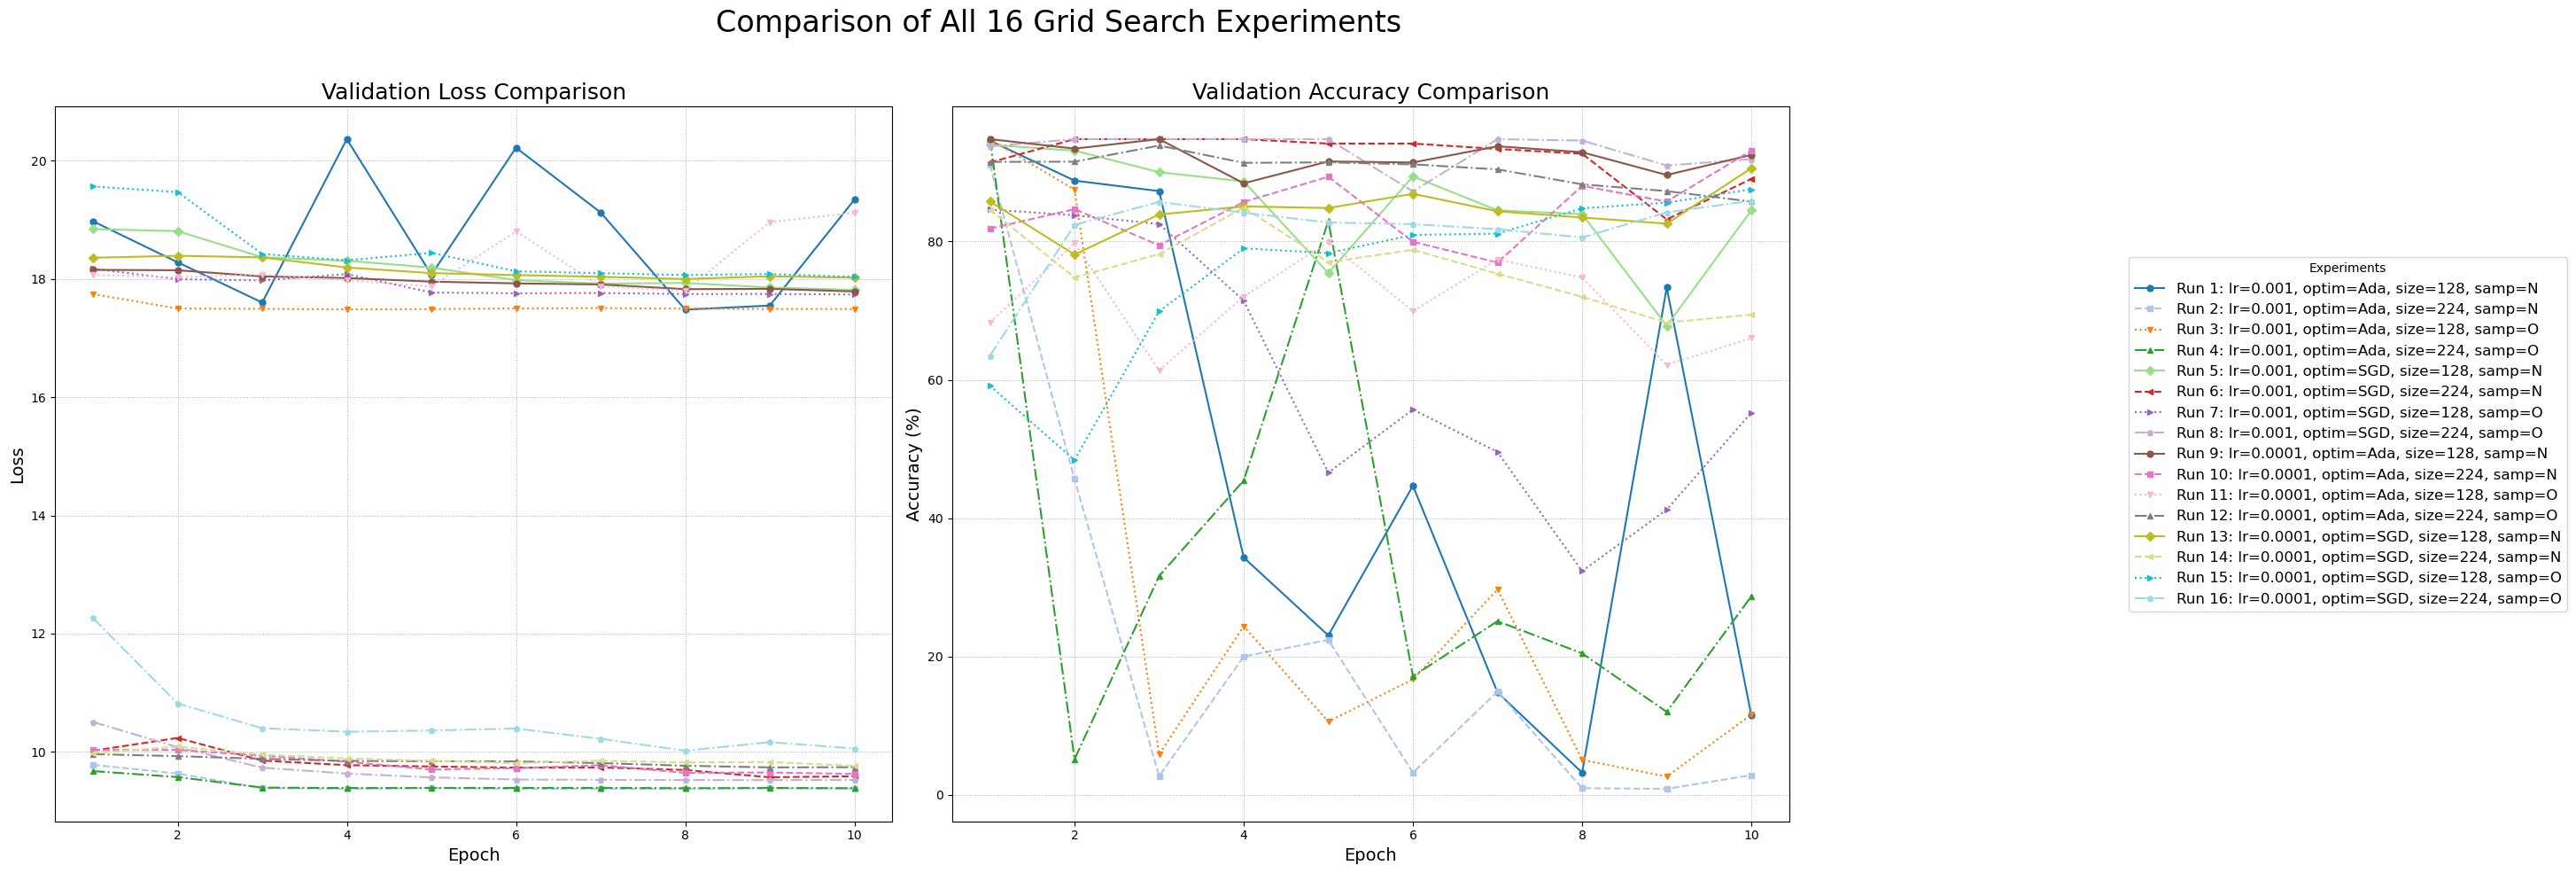

In [49]:
print(f"Plotting a comparison of all {len(all_results)} experiments...")

# Call the new function with your complete results
plot_all_grid_search_results(all_results)

In [50]:
class EfficientNetDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b2(weights='IMAGENET1K_V1')
        # Replace the final fully connected layer
        num_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity() # Remove the original classifier

        # New heads for your task
        self.classifier = nn.Linear(num_features, num_classes)
        self.bbox_head = nn.Linear(num_features, 4)

    def forward(self, x):
        features = self.backbone(x)
        class_scores = self.classifier(features)
        bbox_preds = self.bbox_head(features)
        return class_scores, bbox_preds

In [51]:
def validate_model(model, val_loader, device, image_size, return_preds=False):
    all_labels = []
    all_preds = []
    all_scores = []
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, targets_list in tqdm(val_loader, desc="Validating", unit="batch"):
            images = images.to(device)
            class_scores, bbox_preds = model(images)

            for i in range(images.size(0)):
                target = targets_list[i]
                target_labels = target['labels'].to(device)
                
                if len(target_labels) == 0: continue
                
                # --- (Loss and accuracy logic remains the same) ---
                # This part is fine for training, as it considers all objects
                target_boxes = target['boxes'].to(device)
                target_boxes_norm = target_boxes / torch.tensor([image_size, image_size, image_size, image_size], device=device)
                loss = margin_loss(class_scores[i].unsqueeze(0), target_labels) + 0.1 * bbox_loss(bbox_preds[i], target_boxes_norm)
                running_loss += loss.item()
                predicted = torch.argmax(class_scores[i])
                correct += (predicted == target_labels).sum().item()
                total += len(target_labels)
                # --- End of original logic ---

                # --- NEW, ROBUST LOGIC FOR THE REPORT ---
                # Check if there are any parasite labels in the list.
                # Assumes 'red blood cell' is label 3 and 'leukocyte' is label 2. Adjust if necessary.
                parasite_labels = [lbl for lbl in target_labels if lbl.item() not in [2, 3]] # Find any label that isn't a leukocyte or RBC

                if parasite_labels:
                    # If parasites exist, use the first parasite label as the ground truth.
                    true_label_for_report = parasite_labels[0].cpu().item()
                else:
                    # Otherwise, the ground truth is the first label (which will be an RBC or leukocyte).
                    true_label_for_report = target_labels[0].cpu().item()
                
                all_labels.append(true_label_for_report)
                all_preds.append(predicted.cpu().item())
                
                scores = F.softmax(class_scores[i], dim=0)
                all_scores.append(scores.cpu().numpy())

    epoch_loss = running_loss / len(val_loader) if len(val_loader) > 0 else 0
    accuracy = 100 * correct / total if total > 0 else 0
    print(f"Validation Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

    if return_preds:
        return epoch_loss, accuracy, all_labels, all_preds, all_scores
    else:
        return epoch_loss, accuracy

In [52]:
class MalariaDataset(Dataset):
    def __init__(self, json_path, image_root, transform=None, category_map=None, image_size=128):
        with open(json_path, 'r') as f:
            self.entries = json.load(f)
        self.image_root = image_root
        self.transform = transform
        self.image_size = image_size 

        if category_map is None:
            all_categories = set()
            for item in self.entries:
                for obj in item['objects']:
                    all_categories.add(obj['category'])
            self.category_map = {cat: idx for idx, cat in enumerate(sorted(all_categories))}
        else:
            self.category_map = category_map
        
        # Store labels for each item, useful for sampling
        self.labels = []
        for item in self.entries:
            # We take the label of the first object for simplicity in sampling.
            # A more complex strategy could consider all objects.
            if item['objects']:
                cat = item['objects'][0]['category']
                self.labels.append(self.category_map[cat])
            else:
                # Handle images with no objects if necessary
                self.labels.append(-1) # Placeholder label

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        entry = self.entries[idx]
        pathname_from_json = entry['image']['pathname']
        image_name = os.path.basename(pathname_from_json)
        image_full_path = os.path.join(self.image_root, image_name)

        print("--- DEBUGGING ---")
        print(f"Attempting to open this exact path: '{image_full_path}'")
        print("-------------------")
        
        # We will force a crash here to see the path without hanging
        # raise Exception("Stopping for debug. Please check the path printed above.")

        try:
            image = Image.open(image_full_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: Image not found at {image_full_path}")
            # Use the stored image_size for the placeholder
            placeholder_img = torch.zeros((3, self.image_size, self.image_size)) # <-- FIX
            placeholder_target = {'boxes': torch.empty(0, 4), 'labels': torch.empty(0, dtype=torch.long)}
            return placeholder_img, placeholder_target

        boxes = []
        labels = []
        for obj in entry['objects']:
            bb = obj['bounding_box']
            boxes.append([bb['minimum']['c'], bb['minimum']['r'], bb['maximum']['c'], bb['maximum']['r']])
            labels.append(self.category_map[obj['category']])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {'boxes': boxes, 'labels': labels}
        return image, target


In [53]:
# Your loss functions and collate_fn here...
def margin_loss(class_scores, targets, margin=0.2):
    one_hot_targets = F.one_hot(targets.long(), num_classes=class_scores.size(-1)).float()
    left = F.relu(margin - class_scores) * one_hot_targets
    right = F.relu(class_scores - (1 - margin)) * (1.0 - one_hot_targets)
    return (left + right).sum(dim=-1).mean()

def bbox_loss(preds, targets):
    if preds.dim() == 1:
        preds = preds.unsqueeze(0)
    num_preds, num_targets = preds.size(0), targets.size(0)
    if num_preds > num_targets:
        padding = torch.zeros((num_preds - num_targets, 4), device=targets.device)
        targets = torch.cat([targets, padding], dim=0)
    elif num_targets > num_preds:
        padding = torch.zeros((num_targets - num_preds, 4), device=preds.device)
        preds = torch.cat([preds, padding], dim=0)
    return F.smooth_l1_loss(preds, targets)

def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets


In [ ]:
# --- 2. Prepare Test DataLoader ---
image_size = best_params['image_size']
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- THIS IS THE MISSING CODE ---
# First, get the category map from the training set to ensure consistency
# (We create a temporary training dataset instance just for this)
train_ds_for_map = MalariaDataset(train_json_path, image_path)
category_map = train_ds_for_map.category_map

# Now, create the test dataset using that map
train_ds = MalariaDataset(train_json_path, image_path, transform=train_transform, category_map=category_map, image_size=image_size)
test_ds = MalariaDataset(test_json_path, image_path, transform=test_transform, category_map=category_map, image_size=image_size)

# Finally, create the DataLoader
test_loader = DataLoader(
    test_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=False, 
    collate_fn=custom_collate_fn, # Make sure this function is defined in a cell above
    num_workers=0
)
shuffle = True
sampler = None
# In your run_experiment function or your analysis script...

train_loader = DataLoader(
    train_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=shuffle, 
    sampler=sampler,
    collate_fn=custom_collate_fn,
    num_workers=0  # <-- THE FIX
)

val_loader = DataLoader(
    test_ds, 
    batch_size=best_params['batch_size'], 
    shuffle=False, 
    collate_fn=custom_collate_fn,
    num_workers=0  # <-- THE FIX
)

In [55]:
# --- Add these lines for debugging ---
print(f"Number of samples in test_ds: {len(test_ds)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

# Manually check the first few items from the dataset
print("\n--- Manually inspecting first 3 items from test_ds ---")
for i in range(3):
    image_tensor, target = test_ds[i]
    labels = target['labels']
    boxes  = target['boxes']
    print(f"Item {i}: Labels = {labels}, Boxes = {boxes}, Image Shape = {image_tensor.shape}")


Number of samples in test_ds: 138
Number of batches in test_loader: 5

--- Manually inspecting first 3 items from test_ds ---
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg'
-------------------
Item 0: Labels = tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3]), Boxes = tensor([[1744.,  576., 1883.,  708.],
        [1249.,  863., 1373.,  977.],
        [1573.,  210., 1711.,  335.],
        [1124., 1017., 1253., 1142.],
        [1655.,  572., 1763.,  695.],
        [1307.,  477., 1429.,  590.],
        [ 595.,  962.,  738., 1089.],
        [1699.,  417., 1838.,  551.],
        [ 767., 1162.,  894., 1284.],
        [ 654., 1080.,  774., 1199.],
        [1338.,  961., 1479., 1089.],
        [ 910.,  624., 1034.,  746.],
        [1319., 1122., 

In [56]:
# --- 1. Identify and Load the Best Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-create the model filename from the best parameters
p = best_params
model_filename = f"model_lr_{p['lr']}_optim_{p['optimizer']}_sampling_{p['sampling']}_size_{p['image_size']}.pth"
model_path = os.path.join(models_dir, model_filename)

# Load the model
num_classes = 7 # Or derive it from the dataset
best_model = EfficientNetDetector(num_classes=num_classes).to(device)
# Make sure to load the state dict correctly from your saved checkpoint
checkpoint = torch.load(model_path, map_location=device)
best_model.load_state_dict(checkpoint['model_state_dict'])
print(f"Successfully loaded best model from: {model_path}")


# --- 2. Prepare Test DataLoader ---
image_size = best_params['image_size']
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Successfully loaded best model from: ..\effecientnetb2_model\efficientnet_models\model_lr_0.001_optim_Adam_sampling_none_size_128.pth


C:\Users\shera\AppData\Local\Temp\ipykernel_13848\194157743.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



Running final evaluation on the test set...


Validating:   0%|          | 0/5 [00:00<?, ?batch/s]

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\64985a1e-16bb-4016-a01c-c21a5b86e572.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\c70894fa-50e8-4eed-a5a8-159a20153a49.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\abb72ce2-4193-4dd3-a34c-61c2ee22ccff.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\8db76867-671a-4488-a7b6-991e4dd2e05f.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\ebc4056e-d766-43cf-b6b4-5dac79d96e84.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\d9ecacb0-14c7-4862-930b-18bb51d5f392.jpg'
-------------------

Validating:  20%|██        | 1/5 [00:02<00:11,  2.80s/batch]

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\8111cff9-4c04-448e-990b-9d5010f7be56.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\e6a7743e-4040-40fa-b097-ca6874c469b7.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\e02301ac-68f7-4daf-b2ba-254b917f1cca.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\1e647046-333b-4102-a0c6-4c29405c37b3.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\ef55f2ac-5a04-4986-99ab-0d2b5052ab3e.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\a3548f89-1cb5-4e67-b460-482df95b10ee.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\c6807595-100a-4aa1-a5f6-882a20ca3d32.jpg'
-------------------

Validating:  40%|████      | 2/5 [00:05<00:08,  2.74s/batch]

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\224c80b8-6c55-48cf-b719-96a47d223dc3.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\51a42643-256f-463a-bf22-7fd295caead0.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\f8ebe0c8-a90d-4a64-9f6a-f9985e38c340.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\4b3de416-ac61-43eb-80d0-36b81c4baf82.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\087602a2-288b-4a4d-b01a-524f0d799d89.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\cea1cd9b-9b03-407b-ad8d-348155567dab.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\37b4142a-2c7d-400d-8f01-4e438845a484.jpg'
-------------------

Validating:  60%|██████    | 3/5 [00:07<00:05,  2.56s/batch]

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\b1d312cf-1f52-4955-bf42-58d3664c254a.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\5c399ab9-492c-4bfc-a452-83aba574a3bc.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\96957ec3-de17-41cf-855b-1388814e5918.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\291fe50c-2134-4708-bfa4-09b36ffea123.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\9cf3f75a-354c-46f9-8b53-0a9711ac8bee.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\efb85f8e-c780-4a19-b6ce-555a154b0d10.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\bd4da4f8-8996-47e0-a4e5-a3da5717441e.jpg'
-------------------

Validating:  80%|████████  | 4/5 [00:10<00:02,  2.63s/batch]

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\a2a20600-f851-4db7-90f9-6f7be027c8b5.png'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\e1937e32-85d5-4cd8-bb4a-b9cf8ee7ceeb.png'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\34e024a5-5698-42d4-972f-fee234b4bd64.png'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\04d21589-b777-43c2-86b5-038cbf8c3a4e.png'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\bbecf1a8-a728-4c83-87f8-4dfbac0a1e03.png'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\e4827c85-311a-4df1-89c2-99dad0c3558c.png'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\6695a204-e39c-4418-b904-3f080fdbe7e8.png'
-------------------

Validating: 100%|██████████| 5/5 [00:11<00:00,  2.37s/batch]


Validation Loss: 17.1354, Accuracy: 92.36%

--- Classification Report ---
                precision    recall  f1-score   support

     difficult       0.00      0.00      0.00         4
    gametocyte       0.00      0.00      0.00         7
     leukocyte       0.00      0.00      0.00         0
red blood cell       0.02      1.00      0.04         3
          ring       0.00      0.00      0.00        52
      schizont       0.00      0.00      0.00        10
   trophozoite       0.67      0.03      0.06        62

      accuracy                           0.04       138
     macro avg       0.10      0.15      0.02       138
  weighted avg       0.30      0.04      0.03       138


--- Confusion Matrix ---


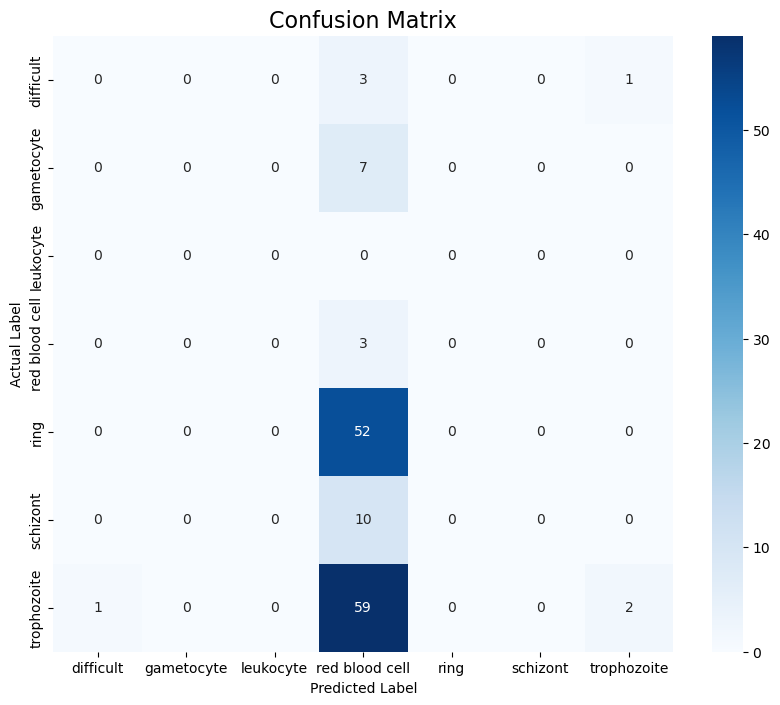

In [69]:
# --- 4. Generate Reports ---
# --- 3. Get Predictions ---
print("\nRunning final evaluation on the test set...")
# This line will now work because 'test_loader' is defined
_, _, y_true, y_pred, y_score = validate_model(best_model, test_loader, device, image_size, return_preds=True)
# Create class_names list automatically from the category_map
# This ensures the order is correct for the classification report
class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]

# --- THIS IS THE FIX ---
# Create a complete list of all possible integer labels [0, 1, 2, 3, 4, 5, 6]
# This will be our "manifest" for the report.
labels_for_report = list(range(len(class_names)))

# Classification Report (Precision, Recall, F1-Score)
print("\n--- Classification Report ---")
# Add the `labels` and `zero_division` parameters to make the function robust
print(classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    labels=labels_for_report,  # <-- Tell sklearn all possible labels to expect
    zero_division=0            # <-- Tell it to print 0.0 if a metric is undefined
))

# Confusion Matrix
print("\n--- Confusion Matrix ---")
# Also add the `labels` parameter here to ensure the matrix has the correct 7x7 size
cm = confusion_matrix(y_true, y_pred, labels=labels_for_report) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


--- Classification Report ---
                precision    recall  f1-score   support

     difficult       0.00      0.00      0.00         4
    gametocyte       0.00      0.00      0.00         7
     leukocyte       0.00      0.00      0.00         0
red blood cell       0.02      1.00      0.04         3
          ring       0.00      0.00      0.00        52
      schizont       0.00      0.00      0.00        10
   trophozoite       0.67      0.03      0.06        62

      accuracy                           0.04       138
     macro avg       0.10      0.15      0.02       138
  weighted avg       0.30      0.04      0.03       138


--- Confusion Matrix ---


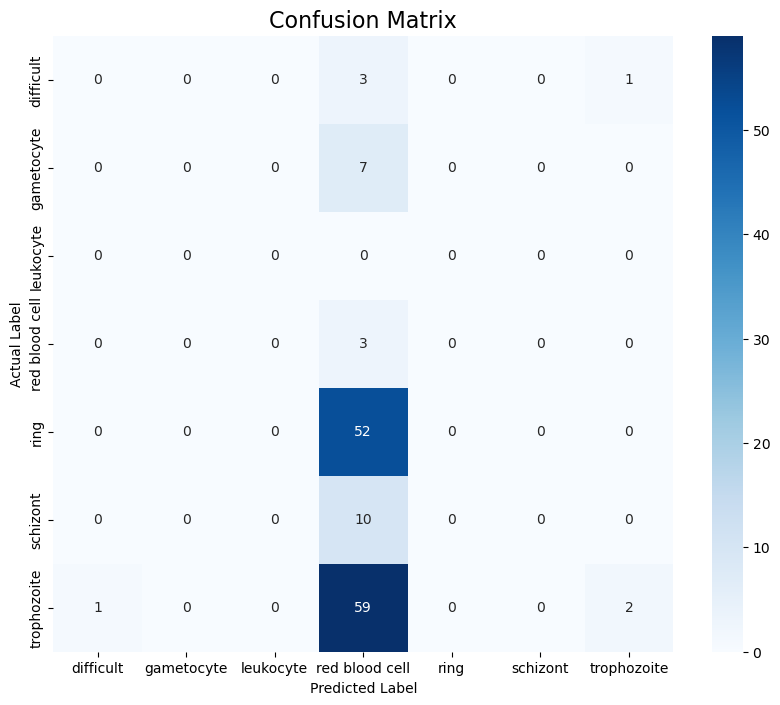

In [58]:
# --- 4. Generate Reports ---

# Create class_names list automatically from the category_map
class_names = [name for name, index in sorted(category_map.items(), key=lambda item: item[1])]

all_possible_labels = list(range(len(class_names)))


# Classification Report (Precision, Recall, F1-Score)
print("\n--- Classification Report ---")
# Add the `labels` parameter to tell the function about all possible classes
print(classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    labels=all_possible_labels,  # <-- The crucial fix!
    zero_division=0              # <-- Good practice to avoid warnings
))


# Confusion Matrix
print("\n--- Confusion Matrix ---")
# Also add the `labels` parameter here to ensure the matrix always has the correct 7x7 size
cm = confusion_matrix(y_true, y_pred, labels=all_possible_labels) 
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Predicting for one image and plotting the box

Found 1 objects with confidence > 0.2
  - Attempting to draw box with coordinates: [1 1 1 2]
  - SKIPPED drawing box because coordinates are invalid.


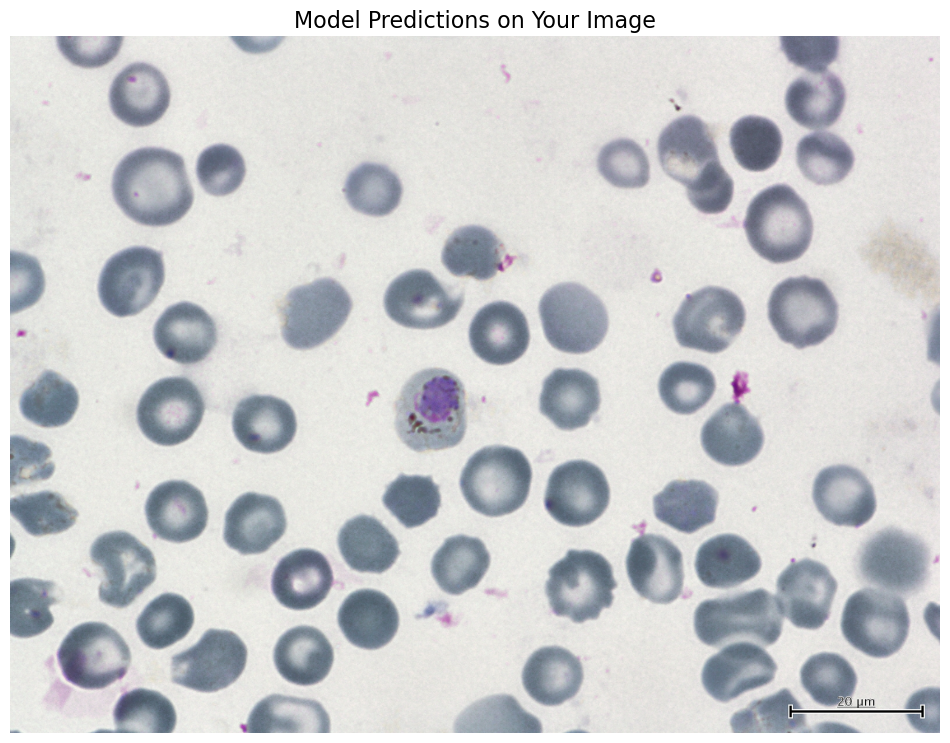

In [73]:
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from torchvision import transforms as T

def predict_on_single_image(model, image_path, device, class_names, threshold=0.5):
    """
    Loads a single image, runs it through the model, and visualizes the predictions.
    Includes debugging checks for bounding box coordinates.
    """
    model.eval()
    
    try:
        image_pil = Image.open(image_path).convert("RGB")
    except FileNotFoundError:
        print(f"Error: The file '{image_path}' was not found.")
        return

    # --- CRUCIAL: Ensure these transforms EXACTLY match your validation/test set ---
    image_transform = T.Compose([
        T.ToTensor(),
        # T.Normalize(mean=[...], std=[...]) # <-- Make sure this is included if you used it in training!
    ])
    
    image_tensor = image_transform(image_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        class_scores, bbox_preds = model(image_tensor)

    class_scores = class_scores.squeeze(0).cpu()
    bbox_preds = bbox_preds.squeeze(0).cpu()
    
    if bbox_preds.ndim == 1: bbox_preds = bbox_preds.unsqueeze(0)
    if class_scores.ndim == 1: class_scores = class_scores.unsqueeze(0)

    draw = ImageDraw.Draw(image_pil)
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except IOError:
        font = ImageFont.load_default()

    high_conf_indices = [i for i, s in enumerate(class_scores) if s.max() > threshold]
    
    print(f"Found {len(high_conf_indices)} objects with confidence > {threshold}")

    for i in high_conf_indices:
        box = bbox_preds[i].numpy().astype(int)
        
        # --- DEBUGGING AND FIX ---
        # 1. Print the predicted coordinates to see what the model is outputting
        print(f"  - Attempting to draw box with coordinates: {box}")
        
        # 2. Add a sanity check to only draw valid boxes
        x_min, y_min, x_max, y_max = box
        if x_max > x_min and y_max > y_min:
            pred_label_idx = class_scores[i].argmax().item()
            score = class_scores[i].max().item()
            label_text = class_names[pred_label_idx]
            display_text = f"{label_text}: {score:.2f}"
            
            draw.rectangle([(x_min, y_min), (x_max, y_max)], outline="red", width=3)
            draw.text((x_min + 5, y_min + 5), display_text, fill="white", font=font)
        else:
            print(f"  - SKIPPED drawing box because coordinates are invalid.")
        # --- END OF FIX ---

    plt.figure(figsize=(12, 12))
    plt.imshow(image_pil)
    plt.title("Model Predictions on Your Image", fontsize=16)
    plt.axis('off')
    plt.show()

# 1. Define the path to YOUR image
my_image_path = r"C:\Users\shera\Desktop\fyp\fyp\dataset\malaria\images\0a747cb3-c720-4572-a661-ab5670a5c42e.png"

# 2. Call the function
predict_on_single_image(
    model=best_model,
    image_path=my_image_path,
    device=device,
    class_names=class_names,
    threshold=0.2 # You can adjust this confidence threshold
)

## Gradcam

In [59]:
images, labels = next(iter(test_loader))

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\64985a1e-16bb-4016-a01c-c21a5b86e572.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\c70894fa-50e8-4eed-a5a8-159a20153a49.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\abb72ce2-4193-4dd3-a34c-61c2ee22ccff.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\8db76867-671a-4488-a7b6-991e4dd2e05f.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\ebc4056e-d766-43cf-b6b4-5dac79d96e84.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\d9ecacb0-14c7-4862-930b-18bb51d5f392.jpg'
-------------------

In [60]:
print(labels)

[{'boxes': tensor([[1744.,  576., 1883.,  708.],
        [1249.,  863., 1373.,  977.],
        [1573.,  210., 1711.,  335.],
        [1124., 1017., 1253., 1142.],
        [1655.,  572., 1763.,  695.],
        [1307.,  477., 1429.,  590.],
        [ 595.,  962.,  738., 1089.],
        [1699.,  417., 1838.,  551.],
        [ 767., 1162.,  894., 1284.],
        [ 654., 1080.,  774., 1199.],
        [1338.,  961., 1479., 1089.],
        [ 910.,  624., 1034.,  746.],
        [1319., 1122., 1457., 1252.],
        [ 477.,  890.,  617., 1004.],
        [ 410.,  514.,  551.,  654.],
        [1802.,  345., 1931.,  491.],
        [  34.,  248.,  184.,  375.],
        [ 755.,  875.,  899., 1014.],
        [ 186.,   85.,  305.,  213.],
        [1487.,  590., 1612.,  708.],
        [1130.,  820., 1233.,  915.],
        [1483.,  867., 1625., 1012.],
        [ 875.,  826., 1002.,  942.],
        [1526.,  326., 1669.,  465.],
        [ 829.,  935.,  977., 1069.],
        [ 414.,  685.,  576.,  809.],
 

In [61]:
from torchvision.utils import make_grid
from gradcam.utils import visualize_cam
from gradcam import GradCAM

def generate_gradcam(model, image_tensor, target_layer, target_class=None):
    """Generates a Grad-CAM heatmap for a given image and model."""
    gradcam = GradCAM(model, target_layer)
    mask, [logit] = gradcam(image_tensor.unsqueeze(0).to(device), class_idx=target_class)
    
    # Create a visual heatmap
    heatmap, result = visualize_cam(mask, image_tensor)
    return result

# --- Find your target layer ---
# You need to find the last convolutional layer in your model.
# Print the model and inspect its structure.
# For efficientnet_b2, a good choice is the last block of the feature extractor.
print(best_model)
# A likely candidate:
target_layer = best_model.backbone.features[-1][0]

EfficientNetDetector(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
            

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\41be1bd3-0d31-4881-bf1f-3ccdfa21ff12.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\64985a1e-16bb-4016-a01c-c21a5b86e572.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\c70894fa-50e8-4eed-a5a8-159a20153a49.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\abb72ce2-4193-4dd3-a34c-61c2ee22ccff.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\8db76867-671a-4488-a7b6-991e4dd2e05f.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\ebc4056e-d766-43cf-b6b4-5dac79d96e84.jpg'
-------------------
--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\d9ecacb0-14c7-4862-930b-18bb51d5f392.jpg'
-------------------

c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
c:\Users\shera\miniconda3\envs\fyp2\Lib\site-packages\gradcam\gradcam.py:81: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43976188..1.0].


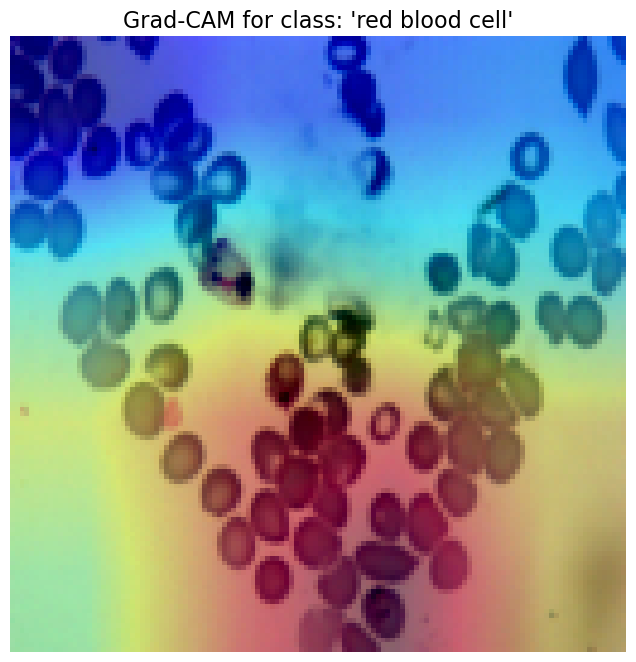

In [62]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from gradcam.utils import visualize_cam
from gradcam import GradCAM

# --- 1. THE CORRECT FIX: A Wrapper for Classifier Tuple Output ---
# This class handles models that return their output as a tuple (e.g., (logits,))
class ClassifierWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        # Get the output from your model
        output = self.model(x)
        # Check if the output is a tuple and return the first element if it is
        if isinstance(output, tuple):
            return output[0]
        # Otherwise, return the output as is
        return output

# --- 2. Wrap Your Model ---
wrapped_model = ClassifierWrapper(best_model).to(device)
wrapped_model.eval() # Ensure the wrapper is in evaluation mode

# Your generate_gradcam function remains the same
def generate_gradcam(model, image_tensor, target_layer, target_class=None):
    """Generates a Grad-CAM heatmap for a given image and model."""
    gradcam = GradCAM(model, target_layer)
    mask, [logit] = gradcam(image_tensor.unsqueeze(0).to(device), class_idx=target_class)
    
    heatmap, result = visualize_cam(mask, image_tensor)
    return result

# --- 3. Get Your Sample Image and Label ---
data_iter = iter(test_loader)
images, labels_data = next(data_iter)

sample_image = images[0]
# Use the same logic as before to get the true label index
true_label_idx = labels_data[0]['labels'][0].item()
true_label_name = class_names[true_label_idx]

# Define your target layer (this path is relative to the original `best_model`)
target_layer = best_model.backbone.features[-1][0] 

# --- 4. Generate and Display the Plot ---
# Pass the NEW wrapped model to the function
gradcam_result_tensor = generate_gradcam(
    model=wrapped_model, 
    image_tensor=sample_image, 
    target_layer=target_layer,
    target_class=true_label_idx
)

# Display the result
gradcam_image_to_plot = gradcam_result_tensor.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(8, 8))
plt.imshow(gradcam_image_to_plot)
plt.title(f"Grad-CAM for class: '{true_label_name}'", fontsize=16)
plt.axis('off')
plt.show()

In [63]:
from torchvision.transforms import ToPILImage
import random

def visualize_prediction(model, dataset, device, category_map, threshold=0.5):
    model.eval()  

    idx = random.randint(0, len(dataset) - 1)
    image, target = dataset[idx]

    image = image.to(device).unsqueeze(0)  

    with torch.no_grad():
        class_scores, bbox_preds = model(image)

    to_pil = ToPILImage()
    image = to_pil(image.squeeze(0).cpu())

    bbox_preds = bbox_preds.squeeze(0).cpu()
    class_scores = class_scores.squeeze(0).cpu()

    if bbox_preds.ndim == 1:
        bbox_preds = bbox_preds.unsqueeze(0)  

    if class_scores.ndim == 1:
        class_scores = class_scores.unsqueeze(0) 

    if bbox_preds.size(0) != class_scores.size(0):
        raise ValueError(f"Mismatch between number of predicted boxes ({bbox_preds.size(0)}) and class scores ({class_scores.size(0)}).")

    selected_boxes = []
    selected_labels = []
    for i, score in enumerate(class_scores):
        if score.max() > threshold: 
            selected_boxes.append(bbox_preds[i].tolist())
            selected_labels.append(score.argmax().item())

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()

    for box, label in zip(selected_boxes, selected_labels):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        rect = plt.Rectangle((x_min, y_min), width, height,
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)

        if label in category_map:
            label_text = category_map[label]
        else:
            label_text = f"Unknown ({label})"  

        ax.text(x_min, y_min - 5, label_text, color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.title("Predictions with Bounding Boxes and Labels")
    plt.show()


--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\df4fd610-fa16-45ca-b3a3-a25a14e5c4e9.jpg'
-------------------


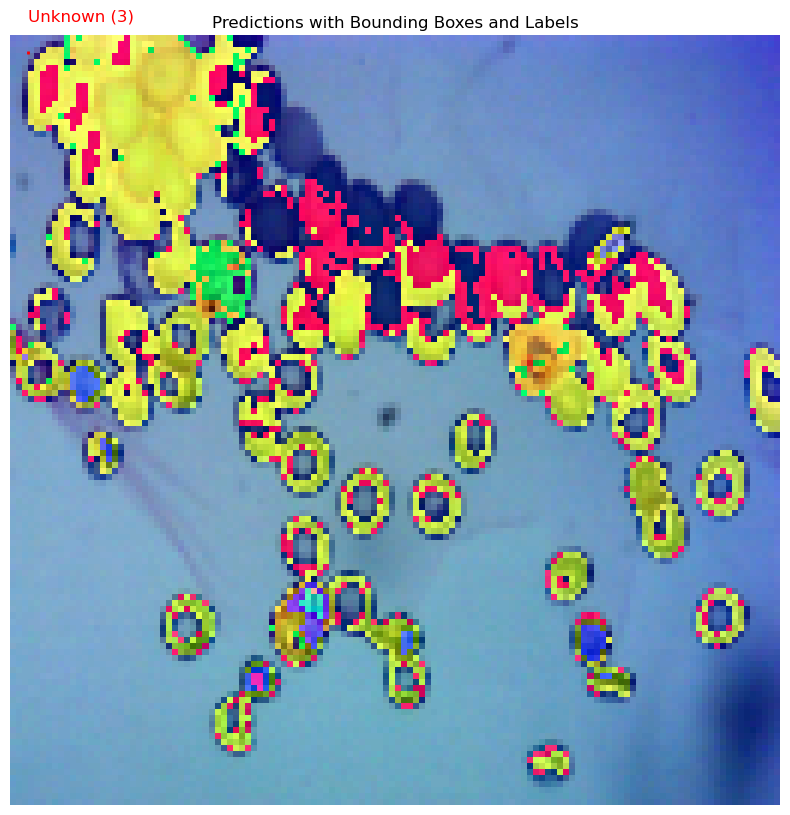

In [64]:
visualize_prediction(best_model, test_ds, device, train_ds.category_map, threshold=0.5)

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\dd7142e4-2d86-4170-a41f-e825743e8907.png'
-------------------


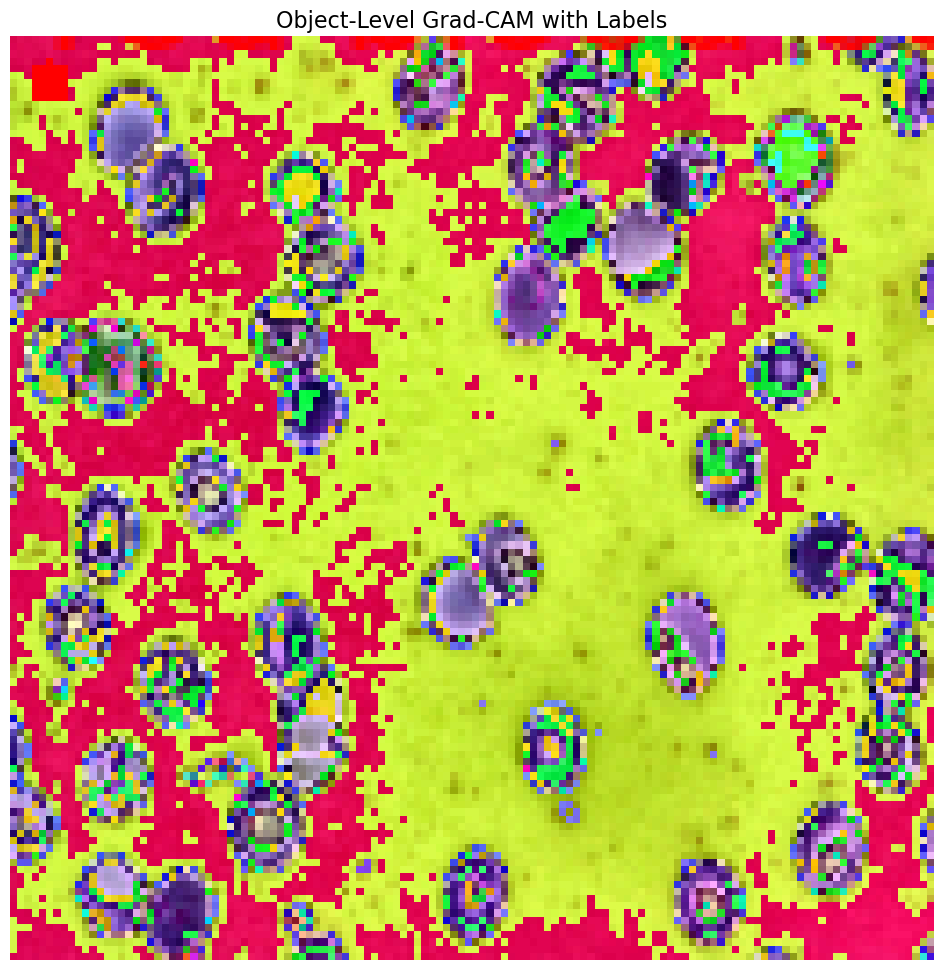

In [65]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import ToPILImage, ToTensor
from PIL import ImageDraw, ImageFont # <-- IMPORT ImageFont
import random

# --- Wrapper and Grad-CAM function (no changes needed) ---
class ClassifierWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        output = self.model(x)
        if isinstance(output, tuple):
            return output[0]
        return output

wrapped_model = ClassifierWrapper(best_model).to(device)
wrapped_model.eval()

def generate_gradcam(model, image_tensor, target_layer, target_class=None):
    gradcam = GradCAM(model, target_layer)
    mask, [logit] = gradcam(image_tensor.unsqueeze(0).to(device), class_idx=target_class)
    heatmap, result = visualize_cam(mask, image_tensor)
    return result

# --- FINAL VISUALIZATION FUNCTION ---
def visualize_object_level_gradcam(detection_model, wrapped_classifier, dataset, device, category_map, threshold=0.5):
    detection_model.eval()

    idx = random.randint(0, len(dataset) - 1)
    image_tensor, target = dataset[idx]

    with torch.no_grad():
        class_scores, bbox_preds = detection_model(image_tensor.unsqueeze(0).to(device))

    class_scores = class_scores.squeeze(0).cpu()
    bbox_preds = bbox_preds.squeeze(0).cpu()

    if bbox_preds.ndim == 1:
        bbox_preds = bbox_preds.unsqueeze(0)
    if class_scores.ndim == 1:
        class_scores = class_scores.unsqueeze(0)

    final_image = ToPILImage()(image_tensor.cpu())

    selected_indices = [i for i, s in enumerate(class_scores) if s.max() > threshold]
    selected_labels = [class_scores[i].argmax().item() for i in selected_indices]

    if not selected_indices:
        print(f"No objects detected with confidence > {threshold}")
        plt.imshow(final_image); plt.axis('off'); plt.show()
        return

    for i, pred_label_idx in zip(selected_indices, selected_labels):
        box = bbox_preds[i].numpy().astype(int)
        x_min, y_min, x_max, y_max = box
        cropped_image_tensor = image_tensor[:, y_min:y_max, x_min:x_max]

        if cropped_image_tensor.shape[1] > 0 and cropped_image_tensor.shape[2] > 0:
            target_layer = detection_model.backbone.features[-1][0]
            gradcam_result = generate_gradcam(
                model=wrapped_classifier,
                image_tensor=cropped_image_tensor,
                target_layer=target_layer,
                target_class=pred_label_idx
            )
            gradcam_pil = ToPILImage()(gradcam_result.cpu())
            final_image.paste(gradcam_pil, (x_min, y_min))

    # --- 5. Draw Bounding Boxes and Labels (WITH FONT FIX) ---
    draw = ImageDraw.Draw(final_image)

    # --- START OF FIX ---
    try:
        # Load a common font with a specific size
        font = ImageFont.truetype("arial.ttf", 24)
    except IOError:
        # If Arial isn't available, use the default font
        print("Arial font not found. Using default font.")
        font = ImageFont.load_default()
    # --- END OF FIX ---

    for i, pred_label_idx in zip(selected_indices, selected_labels):
        box = bbox_preds[i].numpy().astype(int)
        label_text = class_names[pred_label_idx]

        draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)

        # Draw text with the specified font
        draw.text((box[0], box[1] - 25), label_text, fill="red", font=font)

    # --- 6. Display the final composite image ---
    plt.figure(figsize=(12, 12))
    plt.imshow(final_image)
    plt.title("Object-Level Grad-CAM with Labels", fontsize=16)
    plt.axis('off')
    plt.show()

# --- HOW TO RUN IT ---
visualize_object_level_gradcam(
    detection_model=best_model,
    wrapped_classifier=wrapped_model,
    dataset=test_ds,
    device=device,
    category_map=category_map
)

### labels added hopefuly

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\5a2447bf-a92b-4a47-a384-4b2ff020ecdc.jpg'
-------------------


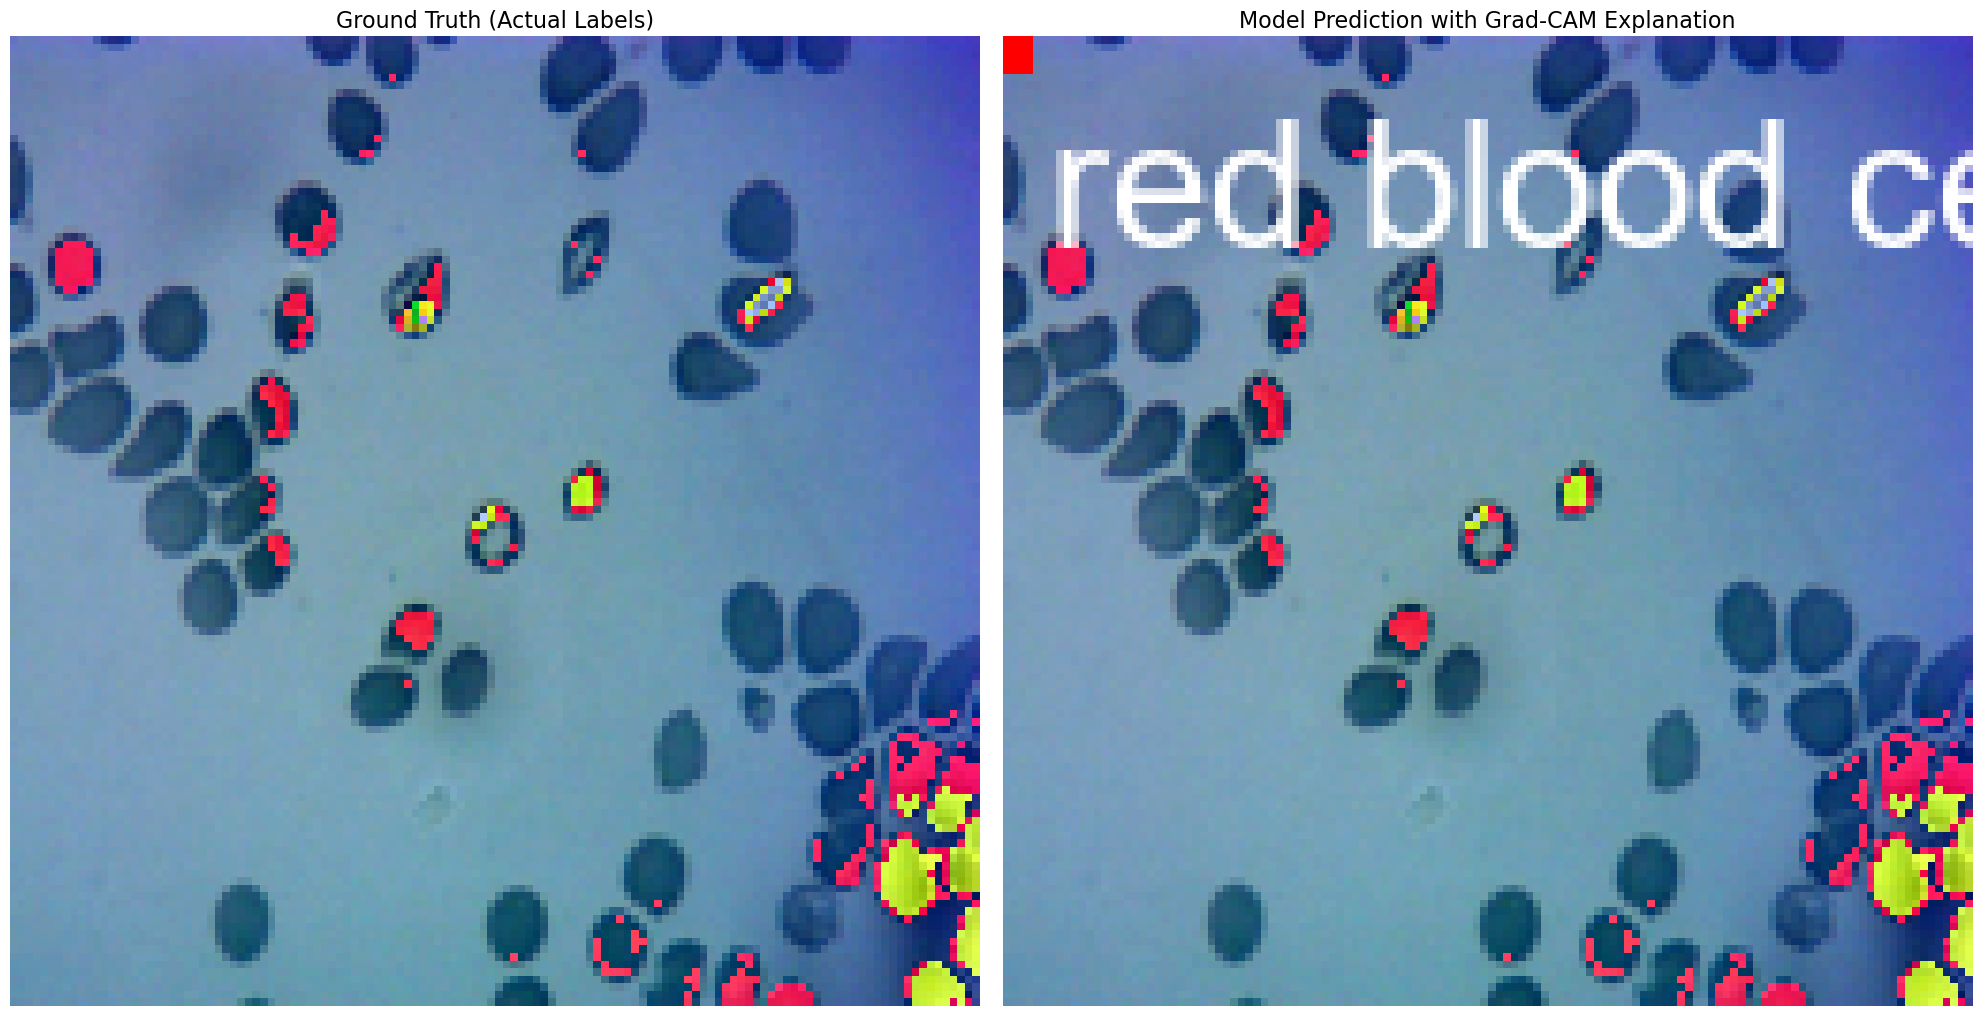

In [67]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import ToPILImage
from PIL import ImageDraw, ImageFont
import random
import numpy as np

# --- Your existing Wrapper and generate_gradcam functions go here ---
class ClassifierWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        output = self.model(x)
        if isinstance(output, tuple):
            return output[0]
        return output

wrapped_model = ClassifierWrapper(best_model).to(device)
wrapped_model.eval()

def generate_gradcam(model, image_tensor, target_layer, target_class=None):
    gradcam = GradCAM(model, target_layer)
    mask, [logit] = gradcam(image_tensor.unsqueeze(0).to(device), class_idx=target_class)
    heatmap, result = visualize_cam(mask, image_tensor)
    return result, heatmap # Return both the blended image and the raw heatmap

# --- FINAL ALL-IN-ONE VISUALIZATION FUNCTION ---
def visualize_and_explain_prediction(detection_model, wrapped_classifier, dataset, device, category_map, threshold=0.5):
    detection_model.eval()
    
    idx = random.randint(0, len(dataset) - 1)
    image_tensor, target = dataset[idx]
    
    # --- 1. Get Model Predictions ---
    with torch.no_grad():
        class_scores, bbox_preds = detection_model(image_tensor.unsqueeze(0).to(device))

    class_scores = class_scores.squeeze(0).cpu()
    bbox_preds = bbox_preds.squeeze(0).cpu()

    if bbox_preds.ndim == 1: bbox_preds = bbox_preds.unsqueeze(0)
    if class_scores.ndim == 1: class_scores = class_scores.unsqueeze(0)

    # --- 2. Prepare Images for Plotting ---
    original_pil = ToPILImage()(image_tensor.cpu())
    prediction_pil = original_pil.copy()

    # --- 3. Generate Grad-CAM for each detected object ---
    selected_indices = [i for i, s in enumerate(class_scores) if s.max() > threshold]
    if not selected_indices:
        print(f"No objects detected with confidence > {threshold}")
        plt.figure(figsize=(8, 8)); plt.imshow(original_pil); plt.axis('off'); plt.show()
        return
        
    for i in selected_indices:
        box = bbox_preds[i].numpy().astype(int)
        pred_label_idx = class_scores[i].argmax().item()
        x_min, y_min, x_max, y_max = box
        
        cropped_tensor = image_tensor[:, y_min:y_max, x_min:x_max]
        if cropped_tensor.shape[1] > 0 and cropped_tensor.shape[2] > 0:
            target_layer = detection_model.backbone.features[-1][0]
            gradcam_result, _ = generate_gradcam(wrapped_classifier, cropped_tensor, target_layer, pred_label_idx)
            prediction_pil.paste(ToPILImage()(gradcam_result.cpu()), (x_min, y_min))

    # --- 4. Prepare for Drawing ---
    draw_original = ImageDraw.Draw(original_pil, "RGBA")
    draw_prediction = ImageDraw.Draw(prediction_pil, "RGBA")
    try:
        font = ImageFont.truetype("arial.ttf", 24)
    except IOError:
        font = ImageFont.load_default()

    # --- 5. Draw Ground Truth and Predictions ---
    # Draw Ground Truth Boxes on the Original Image
    for box, label_idx in zip(target['boxes'], target['labels']):
        box = box.numpy().astype(int)
        label_text = class_names[label_idx.item()]
        draw_original.rectangle([(box[0], box[1]), (box[2], box[3])], outline="lime", width=3)
        # Add a background to the text for readability
        draw_original.text((box[0] + 5, box[1] + 5), label_text, fill="white", font=font)

    # Draw Predicted Boxes and Labels on the Prediction Image
    for i in selected_indices:
        box = bbox_preds[i].numpy().astype(int)
        pred_label_idx = class_scores[i].argmax().item()
        label_text = class_names[pred_label_idx]
        score = class_scores[i].max().item()
        
        display_text = f"{label_text}: {score:.2f}"
        draw_prediction.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)
        # Add a background to the text for readability
        draw_prediction.text((box[0] + 5, box[1] + 5), display_text, fill="white", font=font)

    # --- 6. Create and Display the Final Side-by-Side Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    axes[0].imshow(original_pil)
    axes[0].set_title("Ground Truth (Actual Labels)", fontsize=16)
    axes[0].axis('off')
    
    axes[1].imshow(prediction_pil)
    axes[1].set_title("Model Prediction with Grad-CAM Explanation", fontsize=16)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# --- HOW TO RUN IT ---
visualize_and_explain_prediction(
    detection_model=best_model,
    wrapped_classifier=wrapped_model,
    dataset=test_ds,
    device=device,
    category_map=category_map
)

--- DEBUGGING ---
Attempting to open this exact path: '..\dataset\malaria\images\d67398c5-8b0e-463f-a04e-8583c820786c.png'
-------------------


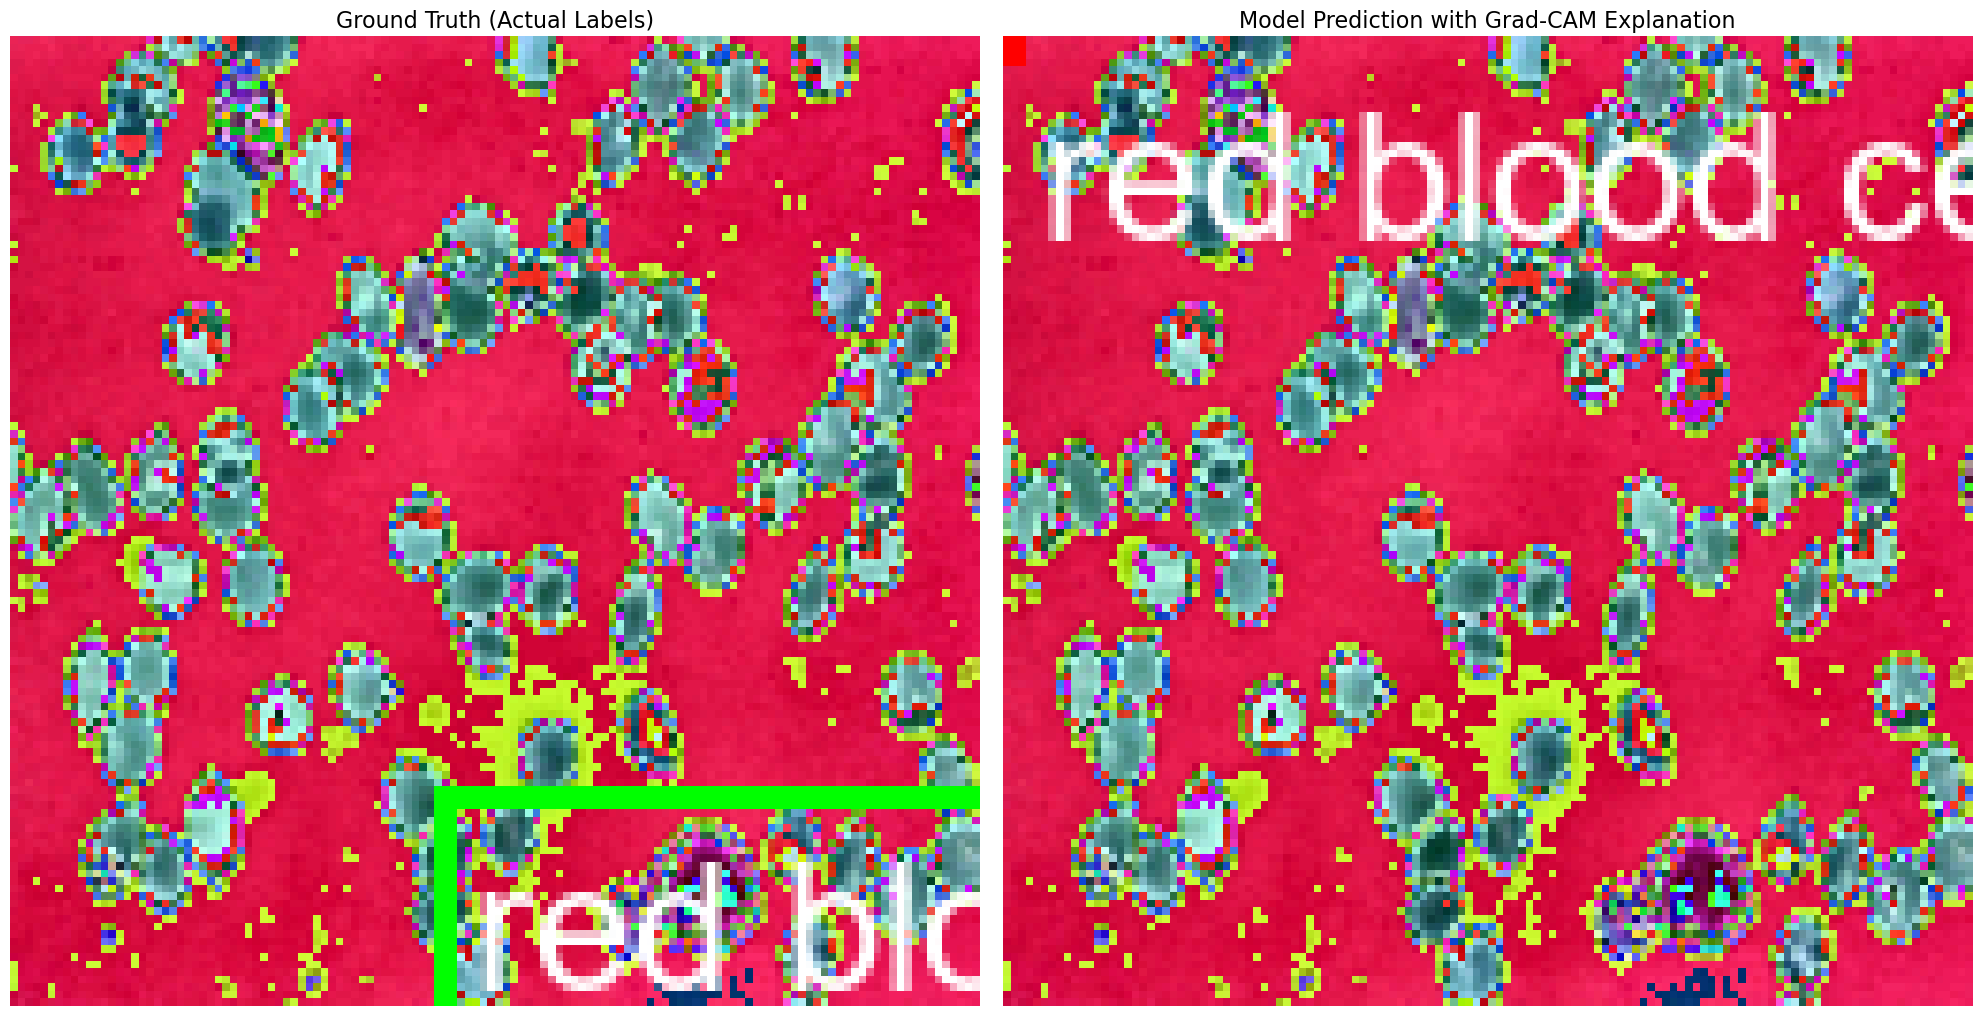

In [68]:
def visualize_object_level_gradcam(detection_model, wrapped_classifier, dataset, device, category_map, threshold=0.5):
    detection_model.eval()
    
    # Reverse category map for labels
    idx_to_class = {v: k for k, v in category_map.items()}
    class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

    # Pick random image
    idx = random.randint(0, len(dataset) - 1)
    image_tensor, target = dataset[idx]

    # --- ORIGINAL IMAGE WITH GROUND TRUTH ---
    original_image = ToPILImage()(image_tensor.cpu()).copy()
    draw_orig = ImageDraw.Draw(original_image)
    for box, label in zip(target["boxes"], target["labels"]):
        box = box.numpy().astype(int)
        label_text = idx_to_class[label.item()]
        draw_orig.rectangle([(box[0], box[1]), (box[2], box[3])], outline="green", width=3)
        draw_orig.text((box[0], box[1] - 20), f"GT: {label_text}", fill="green")

    # --- MODEL PREDICTIONS ---
    with torch.no_grad():
        class_scores, bbox_preds = detection_model(image_tensor.unsqueeze(0).to(device))

    class_scores = class_scores.squeeze(0).cpu()
    bbox_preds = bbox_preds.squeeze(0).cpu()
    if bbox_preds.ndim == 1: bbox_preds = bbox_preds.unsqueeze(0)
    if class_scores.ndim == 1: class_scores = class_scores.unsqueeze(0)

    final_image = ToPILImage()(image_tensor.cpu()).copy()
    draw_pred = ImageDraw.Draw(final_image)

    selected_indices = [i for i, s in enumerate(class_scores) if s.max() > threshold]
    selected_labels = [class_scores[i].argmax().item() for i in selected_indices]

    if not selected_indices:
        print(f"No objects detected with confidence > {threshold}")
        plt.imshow(final_image); plt.axis('off'); plt.show()
        return

    for i, pred_label_idx in zip(selected_indices, selected_labels):
        box = bbox_preds[i].numpy().astype(int)
        x_min, y_min, x_max, y_max = box

        cropped_image_tensor = image_tensor[:, y_min:y_max, x_min:x_max]

        # Grad-CAM for classifier
        if cropped_image_tensor.shape[1] > 0 and cropped_image_tensor.shape[2] > 0:
            target_layer = detection_model.backbone.features[-1][0]
            gradcam_result = generate_gradcam(
                model=wrapped_classifier,
                image_tensor=cropped_image_tensor,
                target_layer=target_layer,
                target_class=pred_label_idx
            )
            gradcam_pil = ToPILImage()(gradcam_result.cpu())
            final_image.paste(gradcam_pil, (x_min, y_min))

        # Draw predicted bounding box + label
        label_text = f"Pred: {class_names[pred_label_idx]}"
        draw_pred.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red", width=3)
        draw_pred.text((box[0], box[1] - 20), label_text, fill="red")

    # --- PLOT SIDE BY SIDE ---
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Ground Truth", fontsize=14)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(final_image)
    plt.title("Predictions + Grad-CAM", fontsize=14)
    plt.axis("off")

    plt.show()

# --- HOW TO RUN IT ---
visualize_and_explain_prediction(
    detection_model=best_model,
    wrapped_classifier=wrapped_model,
    dataset=test_ds, # Use your test dataset object
    device=device,
    category_map=category_map
)
